## Imports
In this block of code, I am importing the dataset that I will use, as well as neccesary libraries for statistical analyses.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from copy import deepcopy
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from scipy import stats
from logging import raiseExceptions
from collections import defaultdict

#The code reads the file and stores it in a dataframe, in which we look at the head (first few rows of the dataframe)
data = pd.read_csv("2018_sqf_database-abbr.csv")
data.head()

,STOP_FRISK_ID,Stop Frisk Time,YEAR2,MONTH2,DAY2,STOP_WAS_INITIATED,ISSUING_OFFICER_RANK,ISSUING_OFFICER_COMMAND_CODE,SUPERVISING_OFFICER_RANK,SUPERVISING_OFFICER_COMMAND_CODE,...,SUSPECT_SEX,SUSPECT_RACE_DESCRIPTION,SUSPECT_HEIGHT,SUSPECT_WEIGHT,SUSPECT_BODY_BUILD_TYPE,SUSPECT_EYE_COLOR,SUSPECT_HAIR_COLOR,STOP_LOCATION_PRECINCT,STOP_LOCATION_FULL_ADDRESS,STOP_LOCATION_BORO_NAME
0,1,19:04:00,2018,January,Monday,Based on C/W on Scene,POM,1,SGT,1,...,MALE,WHITE,5.10,170.0,MED,BRO,BLK,1,VARICK STREET && FRANKLIN STREET,MANHATTAN
1,2,23:00:00,2018,January,Monday,Based on Radio Run,POM,34,SGT,34,...,MALE,BLACK HISPANIC,6.10,250.0,HEA,BRO,BLK,34,DYCKMAN STREET && POST AVENUE,MANHATTAN
2,3,23:55:00,2018,January,Monday,Based on Radio Run,POM,808,SGT,808,...,MALE,WHITE HISPANIC,5.50,150.0,THN,BRO,BLD,43,2245 RANDALL AVENUE,BRONX
3,4,3:23:00,2018,January,Monday,Based on Radio Run,POM,63,SGT,63,...,MALE,AMERICAN INDIAN/ALASKAN NATIVE,5.10,160.0,MED,BRO,BLK,63,EAST 38 STREET && AVENUE L,BROOKLYN
4,5,3:23:00,2018,January,Monday,Based on Radio Run,POM,63,SGT,63,...,MALE,WHITE,5.11,230.0,MED,BRO,BLK,63,EAST 38 STREET && AVENUE L,BROOKLYN


## Subsetting The Dataframe
In this block of code, I am subsetting the dataframe based on columns of interests that pertain to the project

In [2]:
#This block of code looks at the column names and extracts only the important ones based on certain words of interest
columns = data.columns
keywords = {"STOP", "SUSPECT", "SUSPECTED","MINUTES", "FLAG", "PHYSICAL", "FORCE", "BACKGROUND", "RACE", "AGE", "BORO"}
container = []
for titles in columns:
  splitter = set(titles.split("_"))
  #Check for intersection
  checker = keywords.intersection(splitter)
  if len(checker) > 0:
    container.append(titles)
#Based on our keywords, we can then continue to form a subset of the datafame
updated_dataframe = data[container]
cleaner = updated_dataframe["SUSPECT_RACE_DESCRIPTION"] != "0"
updated_dataframe = updated_dataframe[cleaner]
updated_dataframe = updated_dataframe.dropna()

## Functions
The following functions has custom made functions and the functions provided by Daiki in the lab for statistical analyses. I will use these functions in different parts of my code to help with the analysis as I see fit.

In [3]:
#In this block, I am incorporating the functions that will be useful in further analysis
#The following is a function I borrowed from lab that will allow us to get the mean of the data we pass in
def CI_mean(data):
    se = np.std(data)/np.sqrt(len(data))
    low = np.mean(data)-1.96*se
    up = np.mean(data)+1.96*se
    average_info = "Average is: {}".format(np.mean(data))
    confidence_info = "95% CI of mean is: ({}, {})".format(low,up)
    return average_info, confidence_info

def CI_mean_diff(list1, list2):
    s1 = np.var(list1)
    s2 = np.var(list2)
    n1 = len(list1)
    n2 = len(list2)
    se2 = s1/n1 + s2/n2
    se = np.sqrt(se2)

    diff = np.mean(list1) - np.mean(list2)
    low = diff - 1.96 * se
    up = diff + 1.96 * se
    average_information = "The average difference is: {}".format(diff)
    confidence_interval = "The 95% CI is: ({}, {})".format(low, up)
    return [average_information, confidence_interval]

def CI_prop_diff(s1, s2, n1, n2):
    p1 = s1 / n1
    p2 = s2 / n2
    se2p1 = p1 * (1 - p1) / n1
    se2p2 = p2 * (1 - p2) / n2
    se2 = se2p1 + se2p2
    se = np.sqrt(se2)
    low = (p1 - p2) - 1.96 * se
    up = (p1 - p2) + 1.96 * se
    prop_diff = "Proportion difference is: {}".format(p1 - p2)
    confidence_int = "95% CI is: ({}, {})".format(low, up)
    return prop_diff, confidence_int

def group_information(race1, race2, contained_):
  races = [race1, race2]
  information = []
  for race in races:
    race_bool = contained_['SUSPECT_RACE_DESCRIPTION'] == race
    average_, confidence_info_ = CI_mean(contained_[race_bool]["STOP_DURATION_MINUTES"])
    formed = average_ + ' and the ' + confidence_info_
    information.append(formed)
  return information

def counter_altercations(dataframe, list_of_races):
  tracker = defaultdict(lambda: [])
  for race in list_of_races:
    race_booler = dataframe["SUSPECT_RACE_DESCRIPTION"] == race
    updated_df = dataframe[race_booler]
    physical_flags = updated_df.columns[1:]
    summation = updated_df[physical_flags].sum(axis=1)
    if 2 in summation.value_counts():
      difference = len(summation) - summation.value_counts()[2]
      tracker[race] = (difference, len(updated_df))
    else:
      tracker[race] = (len(summation), len(updated_df))
  container = list(tracker.values())
  listers = []
  for i in range(len(list_of_races)):
    no_force = container[i][1] - container[i][0]
    listers.append([list_of_races[i], container[i][0], no_force])
  
  #Make dataframe
  finale = pd.DataFrame(listers, columns = ["Race", "Incidents Involving More than 2 Types of Physical Force", "Incidents with No Force"])
  return finale

###First Visualization: Pie Chart - Percentage of people who were arrested through Stop and Frisk (By Race)
The following code breaks down the dataframe by race and calculates the total number of people that were arrested. Afterward, it subset the total by race


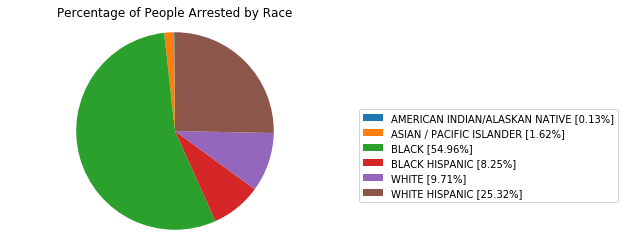

,SUSPECT_ARRESTED_FLAG
SUSPECT_RACE_DESCRIPTION,
AMERICAN INDIAN/ALASKAN NATIVE,4
ASIAN / PACIFIC ISLANDER,49
BLACK,1658
BLACK HISPANIC,249
WHITE,293
WHITE HISPANIC,764


In [4]:

#In this block, I only focus on the race of the different individuals and whether or not they were arrested. From there, I group 
#all of the values to get the count of individuals. I eliminated some rows because their race was marked as 0
suspect_race = updated_dataframe[["SUSPECT_RACE_DESCRIPTION", "SUSPECT_ARRESTED_FLAG"]]
weird_boolean = suspect_race["SUSPECT_RACE_DESCRIPTION"] != "0"
arrested = suspect_race[(suspect_race["SUSPECT_RACE_DESCRIPTION"] != "0") & (suspect_race["SUSPECT_ARRESTED_FLAG"] == 1)]
arrested_improved = arrested.groupby(suspect_race["SUSPECT_RACE_DESCRIPTION"]).sum()

#Step 1: Manually calculate the percentages of people arrested by race
container = [lister[0] for lister in arrested_improved.values]
summation = sum(container)
updated_percentages = [(number/summation) for number in container]

#Step 2: Concatenate labels with their percentages in order to place these in the legend 
#Key Explanation: Due to the presence of small pie slices, it was difficult to illustrate the percentages within the pie without having a cluster
#Therefore, I thought it best to include the percentages in the legend, as I think this is neater

labels_finalized = []
for i in range(len(updated_percentages)):
  stringer = arrested_improved.index[i] + " " + "[" + "{:.2%}".format(updated_percentages[i])+ "]"
  labels_finalized.append(stringer)

#Step 3: Illustrate the pie chart
plt.pie(x=arrested_improved["SUSPECT_ARRESTED_FLAG"], radius = 10, startangle = 90, )
plt.title("Percentage of People Arrested by Race")
plt.legend(labels = labels_finalized, bbox_to_anchor=(1.05, 0.6), loc='upper left', borderaxespad=0)
plt.axis("equal")
plt.show()
arrested_improved


## First Hypothesis Test: Chi Squared Test
In the first hypothesis testing, I am comparing the proportions of Black and White Hispanic Suspects that were arrested as a result of a Stop and Frisk interaction

In [5]:
#Hypothesis Testing for the first visual:
arrested = updated_dataframe[["SUSPECT_RACE_DESCRIPTION", "SUSPECT_ARRESTED_FLAG"]]

#Labels for the dataframe
labels = ["Race", "Arrested", "Not Arrested", "Total", "Proportion"]
container = []
races = ["BLACK", "WHITE HISPANIC"]
for race in races:
  arrested_boolean = (arrested["SUSPECT_RACE_DESCRIPTION"] == race) & (arrested["SUSPECT_ARRESTED_FLAG"] == 1)
  free_boolean = (arrested["SUSPECT_RACE_DESCRIPTION"] == race ) & arrested["SUSPECT_ARRESTED_FLAG"] == 0
  sub_arrested = len(arrested[arrested_boolean])
  sub_free = len(arrested[free_boolean])
  total = sub_arrested + sub_free
  prop = sub_arrested / total
  row = [race, sub_arrested, sub_free, total, prop]
  container.append(row)



data_frame = pd.DataFrame(container, columns = labels)

#Let's calculate the proportion difference
prop_diff, interval = CI_prop_diff(s1=1658, s2=764, n1=10436, n2=10436)
print(prop_diff)
print(interval)
tablet = data_frame[["Arrested", "Not Arrested"]]
chi2, p, dof, expected = stats.chi2_contingency(tablet)
print("chi2:", chi2)
print("p:", p)
print("dof:", dof)
print("expected:", expected)
data_frame
#RELATED TO THE FIRST (1)
#Among the two groups that were arrested the most, there is a statistical significance

Proportion difference is: 0.08566500574932924
95% CI is: (0.07705296149779524, 0.09427705000086324)
chi2: 372.474438872217
p: 5.412985341313904e-83
dof: 1
expected: [[1211. 9225.]
 [1211. 9225.]]


,Race,Arrested,Not Arrested,Total,Proportion
0,BLACK,1658,8778,10436,0.158873
1,WHITE HISPANIC,764,9672,10436,0.073208


## Second Visualization: Grouped Bar Chart: Number of People Arrested in Each Borough by Race

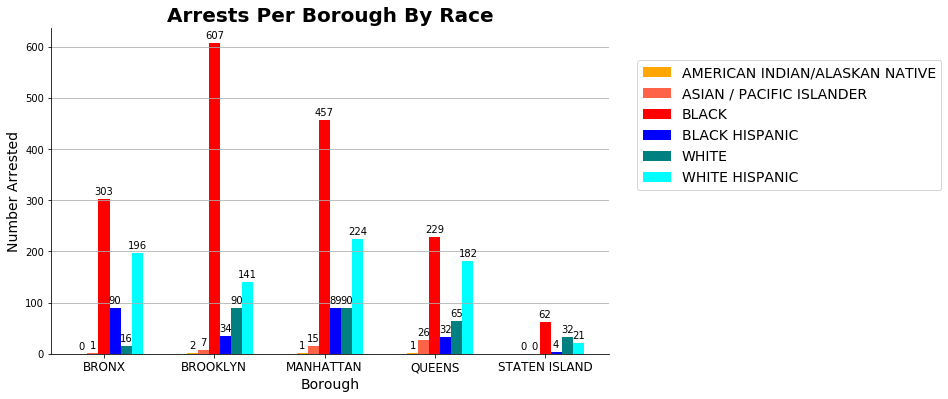

In [6]:
#In this block, I am only focusing on three categories, and I am only considering those with a race (not 0) and individuals that were arrested in all of the boroughs
borough_names = "STOP_LOCATION_BORO_NAME"
race = "SUSPECT_RACE_DESCRIPTION"
arrested_title = "SUSPECT_ARRESTED_FLAG"
data_two = updated_dataframe[[borough_names, race, arrested_title]]
data_two = data_two.dropna()
data_two = data_two[(data_two[race] != "0") & (data_two[arrested_title] == 1)]


#In here, I am grouping the data by race and counting how many of each individuals are appearing in the dataframe and sort the names of the borough
x_axis = list(set(data_two["STOP_LOCATION_BORO_NAME"]))
x_axis.sort()
race_view = data_two.groupby(data_two["SUSPECT_RACE_DESCRIPTION"]).sum()
races = race_view.index
dictionary = defaultdict(lambda: [])
#In here, I count how many arrests took place in each borough
for borough in x_axis:
  for s in races:
    subview = data_two[(data_two[race] == s) & (data_two[borough_names] == borough)]
    dictionary[s].append(subview.shape[0])

#In her, I begin extracting the data I stored to accss the data I will need to plot 
labels = x_axis # Specify the x-axis labels here
data1 = dictionary['AMERICAN INDIAN/ALASKAN NATIVE'] # List of data from 1st category
data2 = dictionary['ASIAN / PACIFIC ISLANDER'] # List of data from 2nd category
data3 = dictionary['BLACK']
data4 = dictionary['BLACK HISPANIC']
data5 = dictionary['WHITE']
data6 = dictionary['WHITE HISPANIC']

x = np.arange(len(labels))
width = 0.1
fig, axs = plt.subplots(figsize=(10,6))
# I label each bar with the race data it reresents
one_bar = axs.bar(x - 0.2, data1, width, label='AMERICAN INDIAN/ALASKAN NATIVE', color='orange')
two_bar = axs.bar(x - 0.1, data2, width, label='ASIAN / PACIFIC ISLANDER', color='tomato')
three_bar = axs.bar(x, data3, width, label='BLACK', color='red')
fourth_bar = axs.bar(x + 0.1, data4, width, label='BLACK HISPANIC', color='blue')
fifth_bar = axs.bar(x + 0.2, data5, width, label='WHITE', color='teal')
sixth_bar = axs.bar(x + 0.3, data6, width, label='WHITE HISPANIC', color='cyan')


axs.set_ylabel('Number Arrested', fontsize=14)
axs.set_xlabel('Borough', fontsize=14)
axs.set_title('Arrests Per Borough By Race',fontsize=20, fontweight='bold')
axs.set_xticks(x)
axs.set_xticklabels(labels, fontsize=12)
axs.legend(bbox_to_anchor=(1.05, 0.9), loc='upper left', borderaxespad=0, fontsize=14)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

values = [*data1, *data2, *data3, *data4, *data5, *data6]
#In this for loop, I use the derefernced list to assign text value to the bars 
for rect, number in zip(axs.patches, values):
    height = rect.get_height()
    axs.text(
        rect.get_x() + rect.get_width() / 2, height + 5, number, ha="center", va="bottom"
    )
plt.grid(axis='y')
plt.show()


## Second Hypothesis Testing: Two Sample t-test
In this hypothesis testing, I am going to compare the average number of arrests of Brooklyn and Staten Island

In [7]:
#Hypothesis Testing Related to the Graph Above
#Final Hypothesis Test: 
def top_borough(dataframe, borough_names, race_groups):
  total_arrests = []
  number_boroughs = len(borough_names)
  
  for borough in borough_names:
    borough_boolean = (dataframe["STOP_LOCATION_BORO_NAME"] == borough) & (dataframe["SUSPECT_ARRESTED_FLAG"] == 1)
    updated_ = dataframe[borough_boolean]
    race_arrests_count = []
    for race in race_groups:
      race_bool = updated_["SUSPECT_RACE_DESCRIPTION"] == race
      updated_with_race = updated_[race_bool]
      race_arrests_count.append(len(updated_with_race))
    total_arrests.append((borough, race_arrests_count))
  return total_arrests

boro_arrested = updated_dataframe[["STOP_LOCATION_BORO_NAME", "SUSPECT_ARRESTED_FLAG", "SUSPECT_RACE_DESCRIPTION"]]
boro_arrested = boro_arrested.dropna()
#Now, let's see which borough had the most arrests
borough_names = list(set(boro_arrested["STOP_LOCATION_BORO_NAME"].values))
races = list(set(boro_arrested["SUSPECT_RACE_DESCRIPTION"].values))
keeper = top_borough(boro_arrested, borough_names, races)
data = [tuplets[1] for tuplets in keeper]
#Construct the dataframe
df = pd.DataFrame()
for i in range(len(data)):
  df.insert(i, borough_names[i], data[i])

#Find the average between Manhattan and Queens
df["Total"] = df["QUEENS"] + df["STATEN ISLAND"] + df["BROOKLYN"] + df["BRONX"] + df["MANHATTAN"]

#Mean Information for Manhattan 
avg_man, ci_man = CI_mean(df["BROOKLYN"])
print("For Brooklyn")
print(avg_man)
print(ci_man)
print("\n")
#Mean Information for Queens
avg_queen, ci_queen = CI_mean(df["STATEN ISLAND"])
print("For Staten Island")
print(avg_queen)
print(ci_queen)
print("\n")
#Mean Difference
contained_borough_info = CI_mean_diff(df["BROOKLYN"],df["STATEN ISLAND"])
print(contained_borough_info[0])
print(contained_borough_info[1])

#Finding the p-value
t_val, p_val = stats.ttest_ind(df["BROOKLYN"],df["STATEN ISLAND"], equal_var=False)

print("Test statistic:", t_val)
print("p-value:", p_val)


#No difference between the number of arrrest that occured in both boroughs

For Brooklyn
Average is: 146.83333333333334
95% CI of mean is: (-22.365757658883865, 316.03242432555055)


For Staten Island
Average is: 19.833333333333332
95% CI of mean is: (2.0462408430116135, 37.620425823655054)


The average difference is: 127.00000000000001
The 95% CI is: (-43.13145814884395, 297.131458148844)
Test statistic: 1.3356250170471717
p-value: 0.23806632576689862


## Third Visualization: Grouped Histogram - Age of Suspects Arrested By Race


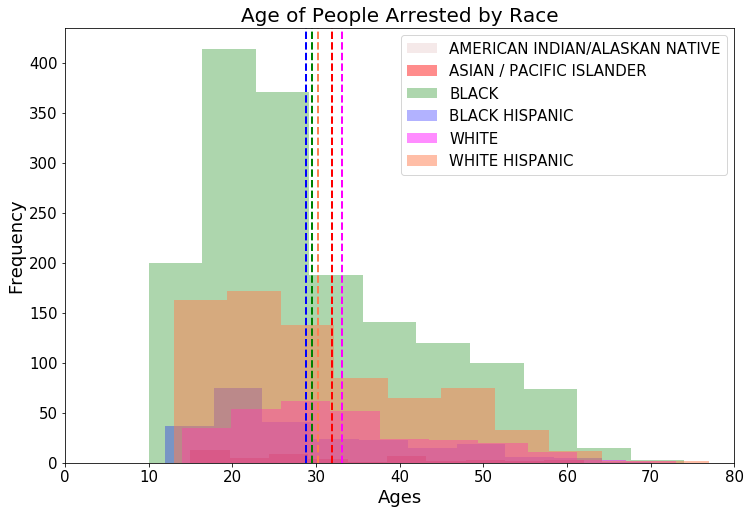

In [8]:
data_ = data
subset_age = updated_dataframe["SUSPECT_REPORTED_AGE"]
#Filter out the ones with no race and the ones with 0 age (just in case)
filter_one = updated_dataframe["SUSPECT_REPORTED_AGE"] != 0
filter_two = updated_dataframe["SUSPECT_RACE_DESCRIPTION"] != "0"
filter_three = updated_dataframe["SUSPECT_ARRESTED_FLAG"] == 1
updated_df = updated_dataframe[(filter_one) & (filter_two) & (filter_three)]
updated_df = updated_df[["SUSPECT_REPORTED_AGE", "SUSPECT_ARRESTED_FLAG", "SUSPECT_RACE_DESCRIPTION"]]

race_category = updated_df.groupby(updated_df["SUSPECT_RACE_DESCRIPTION"]).sum().index
dataframes = []
for race in race_category:
  holder = updated_df[updated_df["SUSPECT_RACE_DESCRIPTION"] == race]["SUSPECT_REPORTED_AGE"]
  dataframes.append(holder)

#Here I am creating the grouped_histogram
fig, axs = plt.subplots(figsize=(12,8))
axs.hist(dataframes[0], color="brown", alpha=0.1, label= race_category[0])
axs.hist(dataframes[1], color="red", alpha=0.45, label= race_category[1])
axs.hist(dataframes[2], color="green", alpha=0.32, label=race_category[2])
axs.hist(dataframes[3], color="blue", alpha=0.3, label=race_category[3])
axs.hist(dataframes[4], color="magenta", alpha=0.45, label=race_category[4])
axs.hist(dataframes[5], color="coral", alpha=0.5, label=race_category[5])
plt.title("Age of People Arrested by Race", fontsize=20)
axs.set_xlabel("Ages", fontsize=18)
axs.set_ylabel("Frequency", fontsize=18)
axs.tick_params(labelsize=15)
axs.legend(prop={'size': 15})

#Adding the lines for the means
axs.axvline(np.mean(dataframes[1]), color='red', ls='dashed', lw=2)
axs.axvline(np.mean(dataframes[2]), color='green', ls='dashed', lw=2)
axs.axvline(np.mean(dataframes[3]), color='blue', ls='dashed', lw=2)
axs.axvline(np.mean(dataframes[4]), color='magenta', ls='dashed', lw=2)
axs.axvline(np.mean(dataframes[5]), color='coral', ls='dashed', lw=2)

plt.xlim(0, 80)
plt.show()

## Third Hypothesis Testing: Two-Sample t-test
In this hypothesis testing, I am comparing the average age of Black Hispanic and White suspects to determine if there is a significant difference in the both the race and age of suspects detained in stop and frisk stops.  

In [9]:
#ANOTHER HYPOTHESIS TESTING: #The Mean Age of those that were arrested
updated_df #Between black and Asian
black_hispanic_boolean = updated_df["SUSPECT_RACE_DESCRIPTION"] == "BLACK HISPANIC"
white_boolean = updated_df["SUSPECT_RACE_DESCRIPTION"] == "WHITE"

black_hispanic_df = updated_df[black_hispanic_boolean]
white_df = updated_df[white_boolean]
white_df = white_df.dropna()
black_hispanic_df = black_hispanic_df.dropna()
#Mean Information for both
#For black
average_bh, ci_bh = CI_mean(black_hispanic_df["SUSPECT_REPORTED_AGE"])
print("For Black Hispanic Suspects:")
print(average_bh)
print(ci_bh)
print('\n')
#For Asian Pacific Islander
average_white, ci_white = CI_mean(white_df["SUSPECT_REPORTED_AGE"])
print("For White Suspects:")
print(average_white)
print(ci_white)
print("\n")
#Now getting the mean difference
inf_container = CI_mean_diff(black_hispanic_df["SUSPECT_REPORTED_AGE"], white_df["SUSPECT_REPORTED_AGE"])
print(inf_container[0])
print(inf_container[1])

t_val, p_val = stats.ttest_ind(black_hispanic_df["SUSPECT_REPORTED_AGE"], white_df["SUSPECT_REPORTED_AGE"], equal_var=False)

print("Test statistic:", t_val)
print("p-value:", p_val)

For Black Hispanic Suspects:
Average is: 28.78048780487805
95% CI of mean is: (27.255425064407014, 30.305550545349085)


For White Suspects:
Average is: 33.06993006993007
95% CI of mean is: (31.660569107707957, 34.479291032152176)


The average difference is: -4.289442265052017
The 95% CI is: (-6.366005455568658, -2.212879074535376)
Test statistic: -4.040957754996849
p-value: 6.13162568885622e-05


## Fourth Hypothesis Test and Visualization: Linear Regression
In the following block of code, I am testing to see if there is a correlation between the age of a suspect and the number of flags raised by an officer

In [10]:
#Hypothesis Testing Related to this
columns = updated_dataframe.columns
keywords = {"MINUTES", "FLAG", "AGE"}
container = []
for titles in columns:
  splitter = set(titles.split("_"))
  #Check for intersection
  checker = keywords.intersection(splitter)
  if len(checker) > 0:
    container.append(titles)
updated_dataframe_two = updated_dataframe[container]
updated_dataframe_two = updated_dataframe_two.drop(["OBSERVED_DURATION_MINUTES"], axis=1)#OBSERVED_DURATION_MINUTES
copier = updated_dataframe_two.columns[1:]
#Now, we calculate the sum
updated_dataframe_two["Total Flags"] = updated_dataframe_two[copier].sum(axis=1)

#Check for outlier
cleaner = (updated_dataframe_two['STOP_DURATION_MINUTES'] < 800) & (updated_dataframe_two["SUSPECT_REPORTED_AGE"] > 0)
updated_dataframe_two = updated_dataframe_two[cleaner]

#Now subset based on groups of interest 
subsetter = updated_dataframe_two[["SUSPECT_REPORTED_AGE", "Total Flags"]]

#Linear Regression
x_vals = subsetter["SUSPECT_REPORTED_AGE"].values
y_vals = subsetter["Total Flags"]

reg_model = OLS(y_vals, sm.add_constant(x_vals)).fit()
display(reg_model.summary())
#Correlation:
corr = stats.pearsonr(subsetter["SUSPECT_REPORTED_AGE"].values, subsetter["Total Flags"])
print("Correlation: {}".format(corr[0]))
#FOR THIRD GRAPH (3)
#Based on summary: Linear Regression line is y = 1.0021 + 6.6122, p-values < 0.05 (it's 0), and 95% CI of slope is 0.998	1.006

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Total Flags   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                 2.728e+05
Date:                Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                        20:46:55   Log-Likelihood:                -22413.
No. Observations:                9862   AIC:                         4.483e+04
Df Residuals:                    9860   BIC:                         4.484e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6165      0.061    108.129      0.000       6.497       6.736
x1             1.0022      0.002    522.307      0.000       0.998       1.006
==============================================================================
Omnibus:                      860.299   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1098.619
Skew:                           0.799   Prob(JB):                    2.74e-239
Kurtosis:                       3.349   Cond. No.                         82.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Correlation: 0.9824039946342985


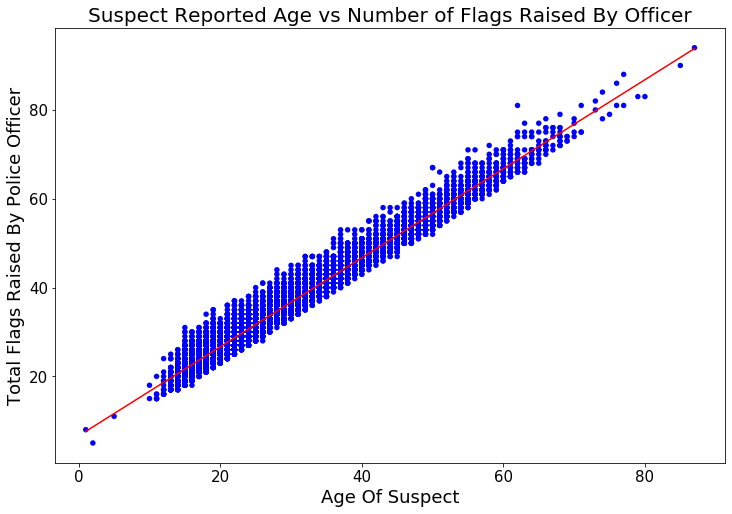

In [11]:
b0 = reg_model.params[0]
b1 = reg_model.params[1]
x_plot = np.linspace(np.min(subsetter['SUSPECT_REPORTED_AGE']), np.max(subsetter['SUSPECT_REPORTED_AGE']), 100)
fig, axs = plt.subplots(figsize=(12,8))
axs.scatter(subsetter['SUSPECT_REPORTED_AGE'], subsetter['Total Flags'], c='blue', edgecolors='none', s=30)
axs.plot(x_plot, x_plot*b1 + b0, color='red')
plt.title("Suspect Reported Age vs Number of Flags Raised By Officer", fontsize=20)
axs.set_xlabel("Age Of Suspect", fontsize=18)
axs.set_ylabel("Total Flags Raised By Police Officer", fontsize=18)
axs.tick_params(labelsize=15)
plt.show()

## Fifth Visualization: Horizontal bar charts - Average Stop Duration by Race

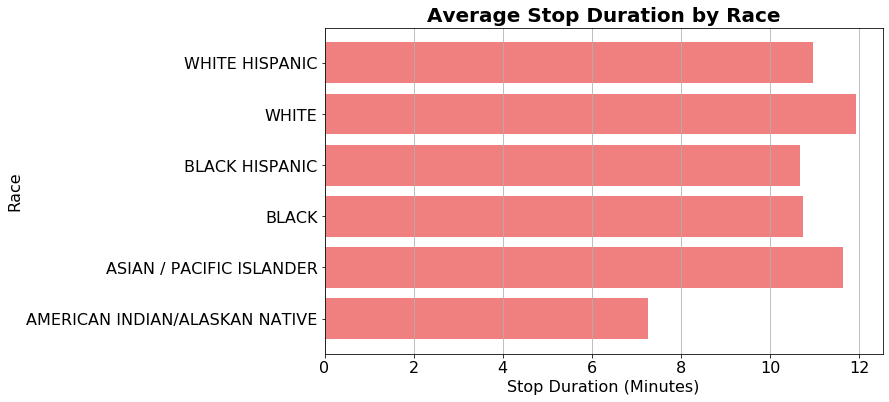

In [12]:
#Subsets the dataframe into the columns of interest
number_of_minutes = list(updated_dataframe["STOP_DURATION_MINUTES"])
bool_vectors = (updated_dataframe["SUSPECT_RACE_DESCRIPTION"] != "0") & (updated_dataframe["SUSPECT_ARRESTED_FLAG"] == 1)
updated_data = updated_dataframe[["SUSPECT_RACE_DESCRIPTION","STOP_DURATION_MINUTES", "SUSPECT_ARRESTED_FLAG"]]
updated_data = updated_data[bool_vectors]
updated_data = updated_data[["SUSPECT_RACE_DESCRIPTION", "STOP_DURATION_MINUTES"]]

races = list(set(updated_data["SUSPECT_RACE_DESCRIPTION"].values))
races.sort()
races

average_stop_duration = []

#For every race, the mean of the stop duration is calculated
for race in races:
  vector = updated_data["SUSPECT_RACE_DESCRIPTION"] == race
  df = updated_data[vector]["STOP_DURATION_MINUTES"]
  average = np.mean(list(df.values))
  average_stop_duration.append(average)


fig, axs = plt.subplots(figsize=(10,6))      
once = axs.barh(races, average_stop_duration, color=('lightcoral'))
axs.set_title("Average Stop Duration by Race", fontsize=20, fontweight="bold")   
axs.set_xlabel("Stop Duration (Minutes)", fontsize=16)
axs.set_ylabel("Race", fontsize=16)
axs.tick_params(labelsize=16)
plt.grid(axis='x')
plt.show()


## Fifth Hypothesis Testing: Two Sample t-test
In this hypothesis test, I am comparing the average stop duration time between Black and White suspects to determine a difference

In [13]:
#This block of code looks at the column names and extracts only the important ones based on certain words of interest
columns = updated_dataframe.columns
keywords = {"STOP", "SUSPECT", "SUSPECTED","MINUTES", "FLAG", "PHYSICAL", "FORCE", "BACKGROUND", "RACE", "AGE", "BORO"}
container = []
for titles in columns:
  splitter = set(titles.split("_"))
  #Check for intersection
  checker = keywords.intersection(splitter)
  if len(checker) > 0:
    container.append(titles)
updated_dataframe = updated_dataframe[container]
cleaner = updated_dataframe["SUSPECT_RACE_DESCRIPTION"] != "0"
updated_dataframe = updated_dataframe[cleaner]
updated_dataframe = updated_dataframe.dropna()
#Now, we want to get the stop duration minutes of those that are black and white - first subset the dataframe into both races
race_bool = (updated_dataframe["SUSPECT_RACE_DESCRIPTION"] == "BLACK") | (updated_dataframe["SUSPECT_RACE_DESCRIPTION"] == "WHITE")
contained_ = updated_dataframe[race_bool]
contained_ = contained_[['STOP_DURATION_MINUTES',"SUSPECT_RACE_DESCRIPTION"]]
#Filter out an outlier
duration_outlier = contained_["STOP_DURATION_MINUTES"] < 800
contained_ = contained_[duration_outlier]
#Find the mean of stop duration minutes for black individuals
races = ["BLACK", "WHITE"]
information = group_information(races[0], races[1], contained_)
for i in range(len(information)):
  print("Average stop duration for {} suspects".format(races[i]))
  print(information[i])
  print('\n')

#Now, we have to find the 95% of mean difference between the two means
subsetter_minutes_black = contained_[contained_["SUSPECT_RACE_DESCRIPTION"] == races[0]]["STOP_DURATION_MINUTES"]
subsetter_minutes_white = contained_[contained_["SUSPECT_RACE_DESCRIPTION"] == races[1]]["STOP_DURATION_MINUTES"]
mean_difference_information = CI_mean_diff(subsetter_minutes_black,subsetter_minutes_white)
for i in range(len(mean_difference_information)):
  print(mean_difference_information[i])

#Now , we just calculate the statistic
t_val, p_val = stats.ttest_ind(subsetter_minutes_black, subsetter_minutes_white, equal_var=False)
print("\n")
print("Test statistic:", t_val)
print("p-value:", p_val)

#Conclusion: There is a statistically significant difference in the amount of time that black suspects are detained relative to their white counterparts.

Average stop duration for BLACK suspects
Average is: 11.072076612903226 and the 95% CI of mean is: (10.686850075606088, 11.457303150200364)


Average stop duration for WHITE suspects
Average is: 12.98118811881188 and the 95% CI of mean is: (12.00926498688814, 13.953111250735622)


The average difference is: -1.9091115059086547
The 95% CI is: (-2.9545941979731385, -0.8636288138441712)


Test statistic: -3.5775001215401305
p-value: 0.00035920846227281136


## Sixth Visualization: Number of Incidents Involving More than Two Types of Physical Force by Race

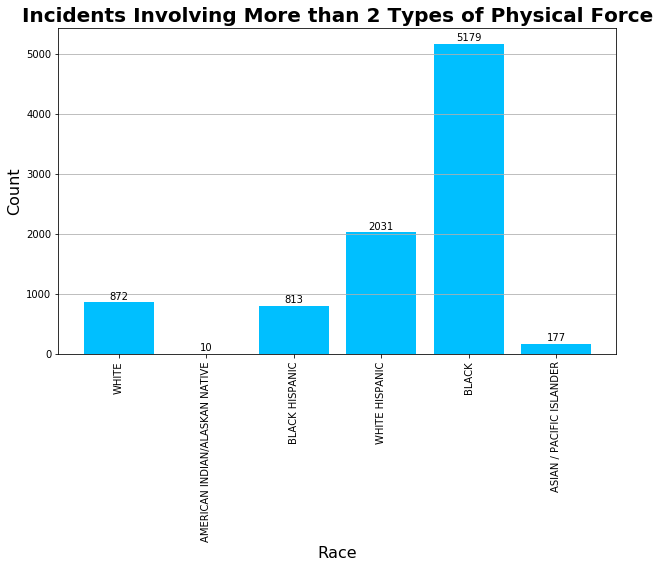

In [14]:
keyword = "PHYSICAL"
container = []
for titles in updated_dataframe.columns:
  splitter = set(titles.split("_"))
  if keyword in splitter:
    container.append(titles)
colnames = deepcopy(container)
colnames.insert(0, "SUSPECT_RACE_DESCRIPTION")
updated_view = updated_dataframe[colnames]
updated_view = updated_view.dropna()
#Step 1: Filter out the 0 race
nonrace_filter = updated_view["SUSPECT_RACE_DESCRIPTION"] != "0"
updated_view = updated_view[nonrace_filter]
races = list(set(updated_view["SUSPECT_RACE_DESCRIPTION"].values))
tracker = counter_altercations(updated_view, races)

#Makes Bar Chart
fig, axs = plt.subplots(figsize=(10,6))        
axs.bar(races, tracker['Incidents Involving More than 2 Types of Physical Force'], color=('deepskyblue'))     
axs.set_title("Incidents Involving More than 2 Types of Physical Force", fontsize=20, fontweight="bold")   
axs.set_xlabel("Race", fontsize=16)
axs.set_ylabel("Count", fontsize=16)
axs.tick_params(labelsize=10)
plt.xticks(rotation = 90) 

#Adds the label to each bar chart 
for rect, number in zip(axs.patches, tracker['Incidents Involving More than 2 Types of Physical Force']):
    height = rect.get_height()
    axs.text(
        rect.get_x() + rect.get_width() / 2, height + 5, number, ha="center", va="bottom"
    )
plt.grid(axis='y')
plt.show() 

## Sixth Hypothesis Testing: Chi Squared Test
In this, I am trying to determine to compare the proportions of physical incidents against those that involved no physical incidents in order to determine if there is a connection between physical force and race of a suspect

In [15]:
table = tracker[["Incidents Involving More than 2 Types of Physical Force", "Incidents with No Force"]]
chi2, p, dof, expected = stats.chi2_contingency(table)
print("chi2:", chi2)
print("p:", p)
print("dof:", dof)
print("expected:", expected)
table["Proportion of Physical Incidents"] = table["Incidents Involving More than 2 Types of Physical Force"] / (table["Incidents Involving More than 2 Types of Physical Force"] + table["Incidents with No Force"])
table

chi2: 10.16892341352536
p: 0.07058794522426265
dof: 5
expected: [[8.78959371e+02 1.31040629e+02]
 [1.21835952e+01 1.81640475e+00]
 [8.19781909e+02 1.22218091e+02]
 [2.00420142e+03 2.98798582e+02]
 [5.18063875e+03 7.72361250e+02]
 [1.86234956e+02 2.77650441e+01]]


,Incidents Involving More than 2 Types of Physical Force,Incidents with No Force,Proportion of Physical Incidents
0,872,138,0.863366
1,10,4,0.714286
2,813,129,0.863057
3,2031,272,0.881893
4,5179,774,0.869982
5,177,37,0.827103


## Sixth Hypothesis Testing Part II: Chi Squared Test
In this hypothesis testing, I am specifically comparing the proportions of Asian/Pacific Islanders and White Hispanics that experienced more than two types of physical force

In [16]:
#Now, I got to explain two groups in particular (black hispanics and white)
subset_tracker_bool = (tracker["Race"] == "ASIAN / PACIFIC ISLANDER") | (tracker["Race"] == "WHITE HISPANIC")
subset_tracker = tracker[subset_tracker_bool]
subset_tracker = subset_tracker.dropna()


#Reporting prop difference
prop_, confidence = CI_prop_diff(177, 2031, 214, 2303)
print(prop_)
print(confidence)
#Now, I am reporting the p-value
small_table = subset_tracker[["Incidents Involving More than 2 Types of Physical Force", "Incidents with No Force"]]
chi2, p, dof, expected = stats.chi2_contingency(small_table)

print("chi2:", chi2)
print("p:", p)
print("dof:", dof)
print("expected:", expected)
subset_tracker["Total"] = subset_tracker["Incidents Involving More than 2 Types of Physical Force"] + subset_tracker["Incidents with No Force"] 
subset_tracker["Proportions"] = subset_tracker["Incidents Involving More than 2 Types of Physical Force"] / (subset_tracker["Incidents Involving More than 2 Types of Physical Force"] + subset_tracker["Incidents with No Force"])
subset_tracker

Proportion difference is: -0.05479037906671913
95% CI is: (-0.1071436179834635, -0.002437140149974766)
chi2: 4.9612016427955625
p: 0.025922188056786068
dof: 1
expected: [[2020.27175209  282.72824791]
 [ 187.72824791   26.27175209]]


,Race,Incidents Involving More than 2 Types of Physical Force,Incidents with No Force,Total,Proportions
3,WHITE HISPANIC,2031,272,2303,0.881893
5,ASIAN / PACIFIC ISLANDER,177,37,214,0.827103
